<a href="https://colab.research.google.com/github/Leonard-H/cnn-sandbox/blob/main/sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import random
from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("/content/drive/MyDrive/cs231n/sandbox/sample_labels.csv")

species_to_idx = {species: idx for idx, species in enumerate(sorted(df["species"].unique()))}
df["label"] = df["species"].map(species_to_idx)

print("Classes:",species_to_idx)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class AnimalDataset(Dataset):
  def __init__(self, df, img_dir, transform=None):
    self.df = df
    self.img_dir = Path(img_dir)
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    img_path = self.img_dir / (str(row["subject_id"]) + ".png")
    image = Image.open(img_path).convert("RGB")
    label = row["label"]
    if self.transform:
      image = self.transform(image)
    return image, label

dataset = AnimalDataset(df, img_dir="/content/drive/MyDrive/cs231n/sandbox/sample", transform=transform)

train_test_split = 0.8
train_size = int(train_test_split * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2 ,pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True)


model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(species_to_idx))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Mounted at /content/drive
Classes: {'dikdik': 0, 'elephant': 1, 'guineafowlvulturine': 2, 'impala': 3, 'zebraplains': 4}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

all_batch_losses = []

for epoch in range(5):
  model.train()
  for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    all_batch_losses.append(loss.item())

model_save_path = "/content/drive/MyDrive/cs231n/sandbox/animal_resnet18.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/cs231n/sandbox/animal_resnet18.pth


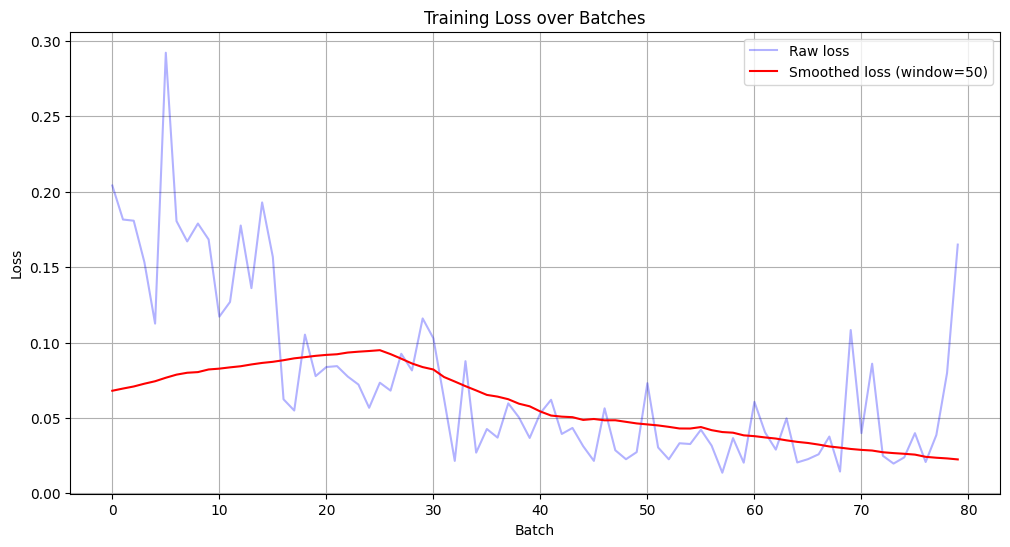

In [ ]:
## show graphic
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(12, 6))
plt.plot(all_batch_losses, color='blue', alpha=0.3, label='Raw loss')
plt.plot(smooth(all_batch_losses, 50), color='red', label='Smoothed loss (window=50)')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Batches')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# load the model
loaded_model = resnet18(weights=None)
num_ftrs = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_ftrs, len(species_to_idx))

model_load_path = "/content/drive/MyDrive/cs231n/sandbox/animal_resnet18.pth"

loaded_model.load_state_dict(torch.load(model_load_path))

loaded_model = loaded_model.to(device)

In [ ]:
def eval_accuracy(model, dataloader, df_lookup):
  model.eval()

  correct_total_flags = {
      "all": [0, 0],
      "dikdik": [0, 0],
      "elephant": [0, 0],
      "guineafowlvulturine": [0, 0],
      "zebraplains": [0, 0],
      "impala": [0,0],
      "day": [0, 0],
      "night": [0, 0],
  }

  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(dataloader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      for i in range(len(labels)):
        label_idx = labels[i].item()
        pred_idx = predicted[i].item()

        row = df_lookup.iloc[batch_idx * dataloader.batch_size + i]

        true_species = row['species']

        hour = pd.to_datetime(row['DateTimeLub']).hour
        time_group = "day" if 6 <= hour < 20 else "night"

        correct = int(pred_idx == label_idx)
        correct_total_flags["all"][0] += correct
        correct_total_flags["all"][1] += 1

        if true_species in correct_total_flags:
          correct_total_flags[true_species][0] += correct
          correct_total_flags[true_species][1] += 1

        correct_total_flags[time_group][0] += correct
        correct_total_flags[time_group][1] += 1

  accuracy = {
      k: (v[0] / v[1]) if v[1] > 0 else None
      for k, v in correct_total_flags.items()
  }

  return accuracy

In [ ]:
df_lookup = dataset.df.iloc[test_dataset.indices].reset_index(drop=True) # create a dataframe for lookup that has the same indices as the test dataset
accuracy = eval_accuracy(loaded_model, testloader, df_lookup)

In [ ]:
acc_table = pd.DataFrame(accuracy.items(), columns=["Category", "Accuracy"])
acc_table["Accuracy"] = (acc_table["Accuracy"] * 100).round(2).astype(str) + "%"
acc_table

,Category,Accuracy
0,all,93.0%
1,dikdik,88.29%
2,elephant,80.0%
3,guineafowlvulturine,99.03%
4,zebraplains,97.02%
5,impala,97.41%
6,day,94.93%
7,night,90.79%


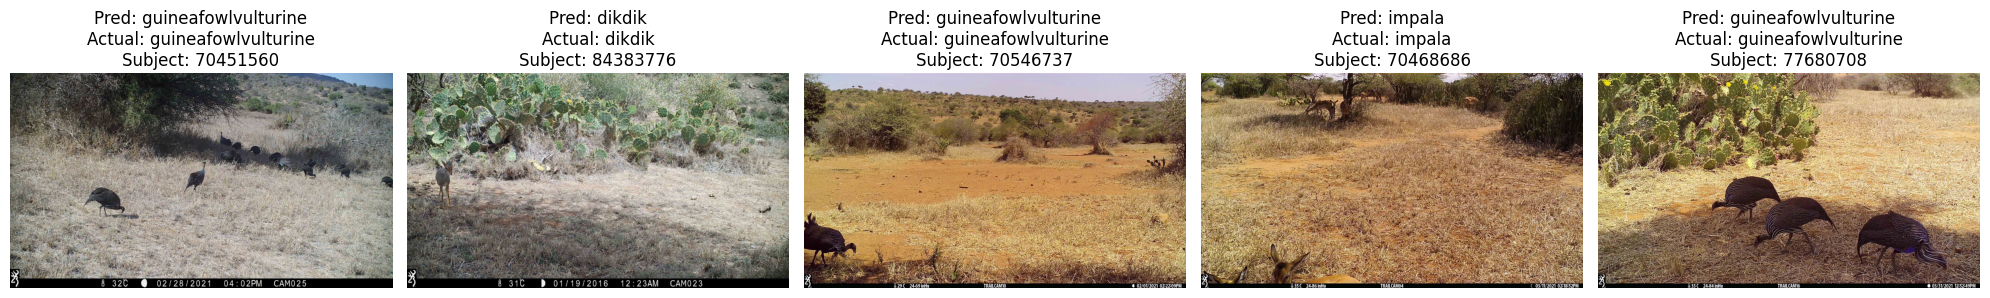

In [ ]:
classes = list(species_to_idx.keys())

img_dir=Path("/content/drive/MyDrive/cs231n/sandbox/sample")

def display_original_image(img_path, ax, title=None):
    try:
        image = Image.open(img_path).convert("RGB")
        ax.imshow(image)
        if title:
            ax.set_title(title)
        ax.axis('off')
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}")
    except Exception as e:
        print(f"Error displaying image {img_path}: {e}")


# five random images
random_indices = random.sample(range(len(test_dataset)), 5)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, dataset_index in enumerate(random_indices):
    original_df_index = test_dataset.indices[dataset_index]
    row = df.iloc[original_df_index]
    img_path = img_dir / (str(row["subject_id"]) + ".png")

    image_for_prediction = transform(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
    outputs = loaded_model(image_for_prediction)
    _, predicted_idx = torch.max(outputs, 1)
    predicted_class = classes[predicted_idx.item()]
    actual_class = classes[row["label"]]

    title = f'Pred: {predicted_class}\nActual: {actual_class}\nSubject: {row["subject_id"]}'
    display_original_image(img_path, axs[i], title=title)


plt.tight_layout()
plt.show()

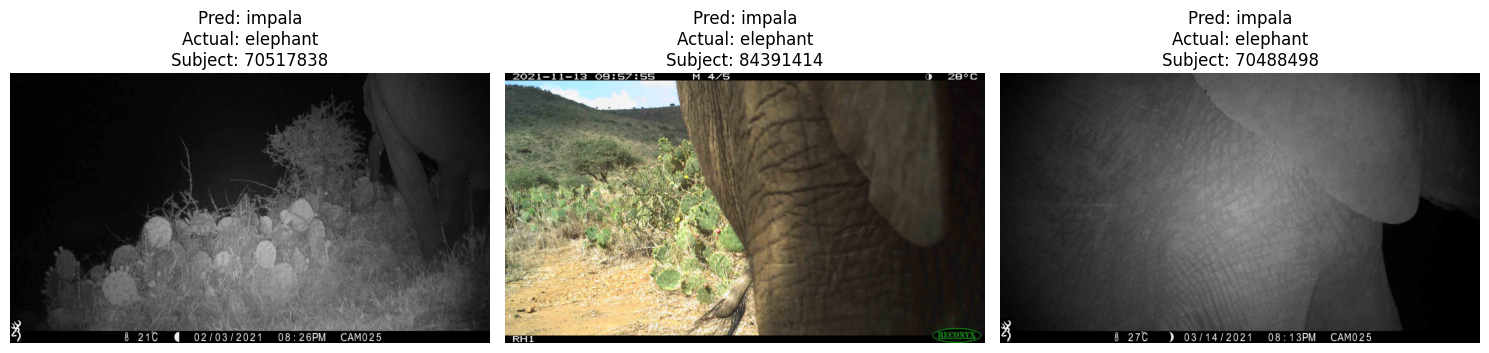

In [ ]:
shuffled_indices = random.sample(range(len(test_dataset)), len(test_dataset))
wrong_predictions = []

for dataset_index in shuffled_indices:
    original_df_index = test_dataset.indices[dataset_index]
    row = df.iloc[original_df_index]
    img_path = img_dir / (str(row["subject_id"]) + ".png")

    try:
        image = Image.open(img_path).convert("RGB")
        image_for_prediction = transform(image).unsqueeze(0).to(device)
        outputs = loaded_model(image_for_prediction)
        _, predicted_idx = torch.max(outputs, 1)

        predicted_class = classes[predicted_idx.item()]
        actual_class = classes[row["label"]]

        if predicted_class != actual_class: wrong_predictions.append((img_path, predicted_class, actual_class, row["subject_id"]))
    except Exception as e:
        print(f"Skipping {img_path}: {e}")
        continue

    if len(wrong_predictions) >= 3: break

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (img_path, pred_class, true_class, subject_id) in enumerate(wrong_predictions[:3]):
    title = f'Pred: {pred_class}\nActual: {true_class}\nSubject: {subject_id}'
    display_original_image(img_path, axs[i], title=title)

plt.tight_layout()
plt.show()
